<a href="https://colab.research.google.com/github/gibaless/APIs/blob/master/Lab3_DL_VGG19_10Layers_TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Embeddings
Students:
Jan Carbonell
Gisela Alessandrello


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Importing packages
import os
import io
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from scipy import stats
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2 
from tensorflow.keras import models, layers
from tensorflow.keras.layers import AveragePooling2D, ZeroPadding2D, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json, Sequential, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.0.0


# New Section

In [0]:
#setting up global variables
# ATADIR = "./simpsons_dataset" #training data directory
DATADIR = '/content/drive/My Drive/MAI/DL/Lab3/simpsons_dataset'
CATEGORIES = ['bart_simpson' , 'homer_simpson', 'lisa_simpson', 'moe_szyslak', 'ned_flanders' ]

image_size=224 #image net has images trained of this size
batch_size=64
epochs=100

In [0]:
training_data = []

for category in CATEGORIES:
    print("Loading images for category: ", category, " ...")
    path = os.path.join(DATADIR, category) #path to alphabets
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        if img != '.DS_Store':
            # print(os.path.join(path,img))
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (224, 224))
            final_img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
            training_data.append([final_img, class_num])


Loading images for category:  bart_simpson  ...
Loading images for category:  homer_simpson  ...
Loading images for category:  lisa_simpson  ...
Loading images for category:  moe_szyslak  ...
Loading images for category:  ned_flanders  ...


In [0]:
# training_data[1:5]
random.shuffle(training_data)

In [0]:
X=[]
y=[]
for features,label in training_data: 
    X.append(features)
    y.append(label)
    # X = np.append(X, features)
    # y = np.append(y, label)
    
X = np.array(X).reshape(-1, image_size, image_size, 3)
X = X.astype('float32')/255.0 # to normalize data
y = to_categorical(y) #one-hot encoding
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print("Train number of samples:", X_train.shape[0])
print("Val number of samples:", X_val.shape[0])

train_data_gen = ImageDataGenerator(
      # validation_split = 0.1, 
     horizontal_flip=True
    ) 

val_data_gen = ImageDataGenerator(
      # validation_split = 0.1, 
     horizontal_flip=True) 

train_data = train_data_gen.flow(X_train, y_train, batch_size = 32, shuffle = True)

val_data = val_data_gen.flow(X_val, y_val, batch_size = 32, shuffle = True)

Train number of samples: 5908
Val number of samples: 657


Classes: B  H  L  M  N 


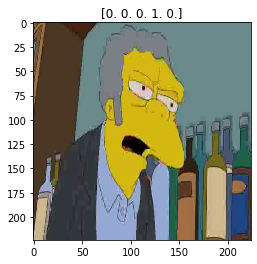

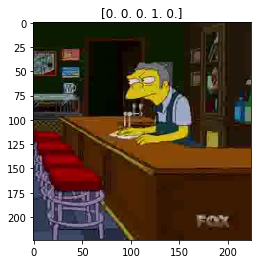

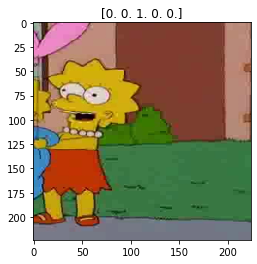

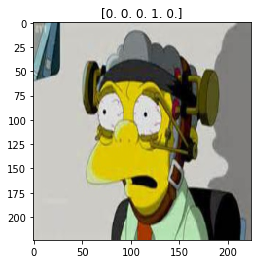

(5908, 224, 224, 3)
(657, 224, 224, 3)
(5908, 5)
(657, 5)


In [0]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[1]

print(train_data)
print(val_data)

print("Classes: B  H  L  M  N ")

x,y = train_data.next()
for i in range(0,4):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.show()


print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

In [0]:
print(y_val[1])

[0. 0. 0. 0. 1.]


In [0]:
# VGG19, InceptionResNetV2 
# conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
conv_base = VGG19(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

80142336/80134624 [==============================] - 2s 0us/step


In [0]:
# Build Model 

model = Sequential()
#Add the base model
for layer in conv_base.layers:
    model.add(layer)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [0]:
# Freeze the layers that won't be trained
# Freeze 18 first layers  for layer in model.layers[:18]:
# Freeze top 10 first layers 
for layer in model.layers[:10]:
    layer.trainable = False

#Add new custom layers
# x = model.output
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# predictions = Dense(29, activation='softmax')(x)
# model_final = Model(inputs=model.input, output=predictions)

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [0]:
# Optimizer 
# adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# sgd = SGD(lr=0.001)
# loss='mean_squared_error'
# loss='categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


In [0]:
history = model.fit_generator(train_data,
                    epochs = 80,
                    # steps_per_epoch = 1,
                    validation_data=val_data,              
                    # validation_steps=3, # , we will use all val data.
                    verbose=1, 
                    # shuffle=True, 
                    # callbacks=[early, checkpoint], 
                    use_multiprocessing=True)


# The returned "history" object holds a record
# of the loss values and metric values during training
print('\nhistory dict:', history.history)

# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/MAI/DL/Lab3/model_lab3.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/MAI/DL/Lab3/model_lab3_weights.h5")
print("Saved model to disk")


Epoch 1/80
185/185 [==============================] - 74s 399ms/step - loss: 0.1080 - accuracy: 0.9626 - val_loss: 0.4777 - val_accuracy: 0.8661
Epoch 2/80
185/185 [==============================] - 73s 397ms/step - loss: 0.1135 - accuracy: 0.9638 - val_loss: 0.3530 - val_accuracy: 0.9041
Epoch 3/80
185/185 [==============================] - 74s 398ms/step - loss: 0.1139 - accuracy: 0.9607 - val_loss: 0.4826 - val_accuracy: 0.8828
Epoch 4/80
185/185 [==============================] - 74s 399ms/step - loss: 0.1443 - accuracy: 0.9518 - val_loss: 0.6213 - val_accuracy: 0.8661
Epoch 5/80
185/185 [==============================] - 74s 398ms/step - loss: 0.0865 - accuracy: 0.9702 - val_loss: 0.3376 - val_accuracy: 0.9163
Epoch 6/80
185/185 [==============================] - 74s 399ms/step - loss: 0.1583 - accuracy: 0.9484 - val_loss: 0.4087 - val_accuracy: 0.8995
Epoch 7/80
185/185 [==============================] - 74s 398ms/step - loss: 0.1443 - accuracy: 0.9533 - val_loss: 0.4168 - val_ac

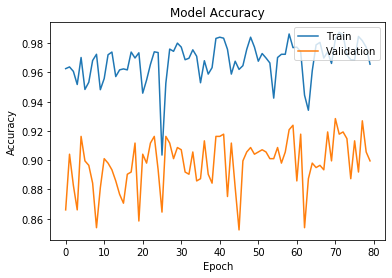

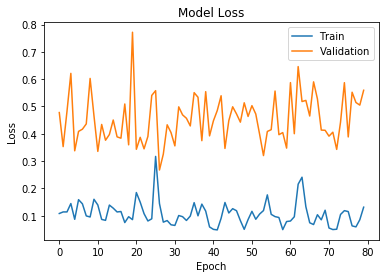

In [0]:
##Model Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


##Model Accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Test to predict model


In [0]:
CATEGORIES = ['bart_simpson' , 'homer_simpson', 'lisa_simpson', 'moe_szyslak', 'ned_flanders' ]
num_classes = 5
test_data = []
test_labels = []
image_data = []
TESTDIR = '/content/drive/My Drive/MAI/DL/Lab3/simpsons_testset'

for category in CATEGORIES:
    print("Loading test images for category: ", category, " ...")
    path = os.path.join(TESTDIR, category) 
    class_num = CATEGORIES.index(category)
    print("Class: ",  class_num)
    for img in os.listdir(path):
        if img != '.DS_Store':
            # print(img)
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            # new_array = cv2.resize(img_array, (224, 224))
            new_array = cv2.resize(img_array, (224, 224)).astype('float32') / 255.
            final_img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
            test_data.append(final_img)
            test_labels.append(class_num)
            image_data.append(img)
    X_test = np.array(test_data)
    y_test = np.array(test_labels)
    y_test = to_categorical(y_test, num_classes)
    print("Test set", X_test.shape, y_test.shape)

# X_test, y_test

probabilities = model.predict(X_test)
y_pred = probabilities > 0.5
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)


Loading test images for category:  bart_simpson  ...
Class:  0
Test set (50, 224, 224, 3) (50, 5)
Loading test images for category:  homer_simpson  ...
Class:  1
Test set (100, 224, 224, 3) (100, 5)
Loading test images for category:  lisa_simpson  ...
Class:  2
Test set (150, 224, 224, 3) (150, 5)
Loading test images for category:  moe_szyslak  ...
Class:  3
Test set (200, 224, 224, 3) (200, 5)
Loading test images for category:  ned_flanders  ...
Class:  4
Test set (249, 224, 224, 3) (249, 5)


In [0]:
y_pred

array([1, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       2, 4, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 1, 4, 2,
       4, 0, 4, 4, 4, 4, 4])

In [0]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4])

In [0]:
image_data

['bart_simpson_48.jpg',
 'bart_simpson_49.jpg',
 'bart_simpson_39.jpg',
 'bart_simpson_11.jpg',
 'bart_simpson_10.jpg',
 'bart_simpson_38.jpg',
 'bart_simpson_12.jpg',
 'bart_simpson_13.jpg',
 'bart_simpson_17.jpg',
 'bart_simpson_16.jpg',
 'bart_simpson_28.jpg',
 'bart_simpson_14.jpg',
 'bart_simpson_8.jpg',
 'bart_simpson_29.jpg',
 'bart_simpson_15.jpg',
 'bart_simpson_9.jpg',
 'bart_simpson_24.jpg',
 'bart_simpson_30.jpg',
 'bart_simpson_18.jpg',
 'bart_simpson_19.jpg',
 'bart_simpson_5.jpg',
 'bart_simpson_31.jpg',
 'bart_simpson_4.jpg',
 'bart_simpson_25.jpg',
 'bart_simpson_33.jpg',
 'bart_simpson_27.jpg',
 'bart_simpson_26.jpg',
 'bart_simpson_7.jpg',
 'bart_simpson_6.jpg',
 'bart_simpson_2.jpg',
 'bart_simpson_32.jpg',
 'bart_simpson_3.jpg',
 'bart_simpson_36.jpg',
 'bart_simpson_37.jpg',
 'bart_simpson_23.jpg',
 'bart_simpson_22.jpg',
 'bart_simpson_1.jpg',
 'bart_simpson_21.jpg',
 'bart_simpson_0.jpg',
 'bart_simpson_34.jpg',
 'bart_simpson_20.jpg',
 'bart_simpson_35.jpg',
 '

Confusion matrix, without normalization
[[34  5  1  9  1]
 [ 0 47  0  2  1]
 [ 0  0 49  0  1]
 [ 1  0  0 49  0]
 [ 2  2  1  0 44]]
Normalized confusion matrix
[[0.68 0.1  0.02 0.18 0.02]
 [0.   0.94 0.   0.04 0.02]
 [0.   0.   0.98 0.   0.02]
 [0.02 0.   0.   0.98 0.  ]
 [0.04 0.04 0.02 0.   0.9 ]]
   


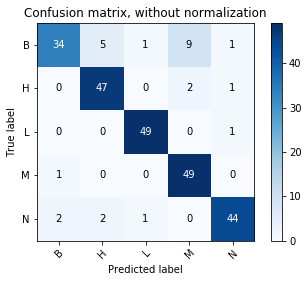

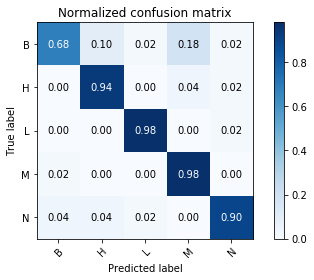

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Plot normalized confusion matrix
mat = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['B','H','L','M','N'] #classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    # fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=[0,1,2,3,4], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=[0,1,2,3,4], normalize=True, title='Normalized confusion matrix')
print("   ")
plt.tight_layout(w_pad=5.5, h_pad=5.0)
plt.show()

In [0]:
probabilities = model.predict(X_test)
y_prednew = probabilities > 0.5

score = model.evaluate(X_test, y_prednew, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print(score)

249/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================